# Plan: Aim is to explore customer segmentation, using the Apriori Algorithm to see how different types of customer buy different items

1. Customer segmentation: split customers into clusters
2. Run Apriori algorithm for each cluster
3. Then use R library to visualise 

https://archive.ics.uci.edu/ml/datasets/Online+Retail

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
uci_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(uci_url)

In [3]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [4]:
c_count=df['InvoiceNo'].str.contains('C').sum()
if c_count>0:
    print ("There are {m} cases".format(m=c_count))

There are 9288 cases


In [5]:
df.Description.value_counts(ascending=True)

PINK BEADS+HAND PHONE CHARM              1
SET 10 CARDS TRIANGLE ICONS  17220       1
ETCHED GLASS STAR TREE DECORATION        1
sold in set?                             1
PINK ALLIUM  ARTIFICIAL FLOWER           1
                                      ... 
LUNCH BAG RED RETROSPOT               1638
PARTY BUNTING                         1727
JUMBO BAG RED RETROSPOT               2159
REGENCY CAKESTAND 3 TIER              2200
WHITE HANGING HEART T-LIGHT HOLDER    2369
Name: Description, Length: 4223, dtype: int64

In [6]:
df.Description.nunique()

4223

In [7]:
df[df['Description']=='rusty thrown away']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
487975,577787,23055,rusty thrown away,-398,2011-11-21 16:28:00,0.0,NaN,United Kingdom


# DataCamp: Customer Segmentation Course
## Section 1: Cohort Analysis
### Assign daily acquisition cohort

In [8]:
online = df.copy(deep=True)

In [9]:
# Define a function that will parse the date
def get_day(x): return dt.datetime(x.year, x.month, x.day)

In [10]:
# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDay']

In [11]:
grouping.head()

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541768   2011-12-09
541769   2011-12-09
541770   2011-12-09
541771   2011-12-09
541772   2011-12-09
Name: InvoiceDay, Length: 21211, dtype: datetime64[ns]

In [12]:
# Assign a minimum InvoiceDay value to the dataset
online['CohortDay'] = grouping.transform('min')

# View the top 5 rows
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


### Calculate time offset in days - part 1

In [13]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [14]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

### Calculate time offset in days - part 2

In [15]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndexDay'] = years_diff * 365 + months_diff * 30 + days_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndexDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0


## Customer Retention

### Calculate retention rate from scratch

In [16]:
online.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndexDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0


In [17]:
online['CohortMonth']= pd.to_datetime(online['CohortDay']).dt.to_period('M')
online['InvoiceMonth']=pd.to_datetime(online['InvoiceDay']).dt.to_period('M')

In [18]:
online.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndexDay,CohortMonth,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12


In [19]:
# Extract the difference in days from all previous values
online['CohortIndexMonth'] = years_diff * 12 + months_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndexDay,CohortMonth,InvoiceMonth,CohortIndexMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12,1.0


In [82]:
df_day = online.groupby('InvoiceDay').InvoiceNo.nunique()
df_day = df_day.to_frame()
df_day.head()

,InvoiceNo
InvoiceDay,
2010-12-01,143
2010-12-02,167
2010-12-03,108
2010-12-05,95
2010-12-06,133


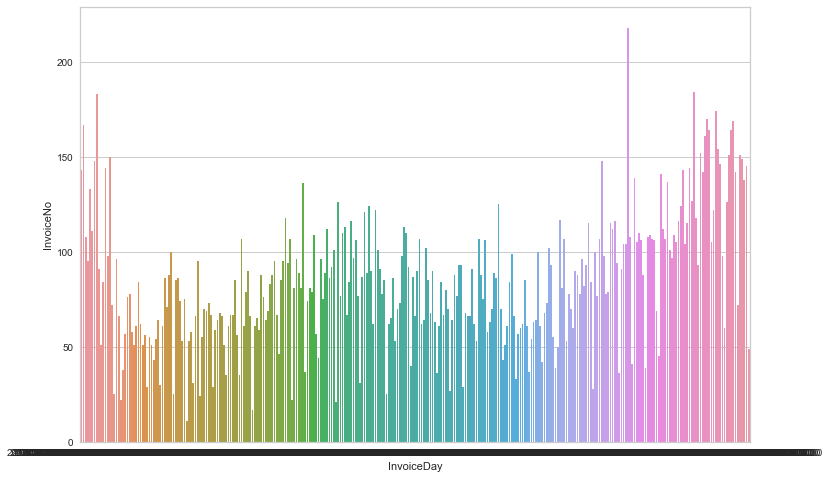

In [83]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(df_day.index, df_day.InvoiceNo)

plt.show()

In [20]:
df_month = online.groupby('InvoiceMonth').InvoiceNo.nunique()
df_month = df_time.to_frame()
df_month.head()

,InvoiceNo
InvoiceMonth,
2010-12,2025
2011-01,1476
2011-02,1393
2011-03,1983
2011-04,1744


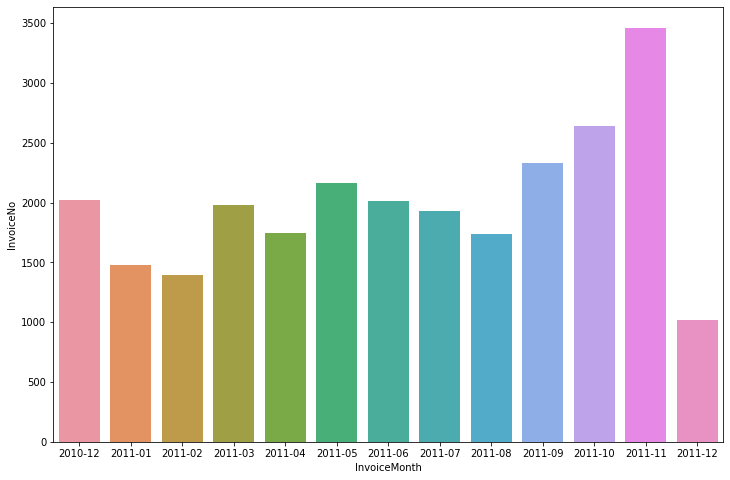

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(df_month.index, df_month.InvoiceNo)

plt.show()
fig.savefig("time_series.png")

In [89]:
online.describe()

,Quantity,UnitPrice,CustomerID,CohortIndexDay,CohortIndexMonth
count,541909.000000,541909.000000,406829.000000,406829.000000,406829.000000
mean,9.552250,4.611114,15287.690570,131.612707,5.185088
std,218.081158,96.759853,1713.600303,119.273856,3.859473
min,-80995.000000,-11062.060000,12346.000000,1.000000,1.000000
25%,1.000000,1.250000,13953.000000,1.000000,1.000000
50%,3.000000,2.080000,15152.000000,112.000000,4.000000
75%,10.000000,4.130000,16791.000000,233.000000,8.000000
max,80995.000000,38970.000000,18287.000000,374.000000,13.000000


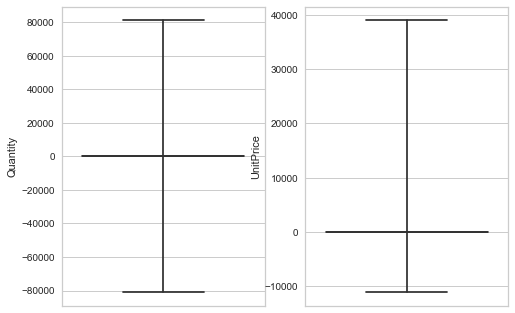

In [88]:
plt.figure()

plt.subplot(1,2,1)
sns.boxplot(y='Quantity', whis='range', data=online)

plt.subplot(1,2,2)
sns.boxplot(y='UnitPrice', whis='range', data=online)

plt.show()

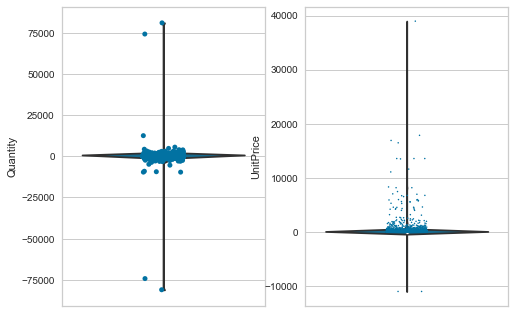

In [96]:
plt.figure()

plt.subplot(1,2,1)
sns.violinplot(y='Quantity', whis='range', data=online)
sns.stripplot(y='Quantity', jitter=True, data=online)

plt.subplot(1,2,2)
sns.violinplot(y='UnitPrice', whis='range', data=online)
sns.stripplot(y='UnitPrice', jitter=True, size=1.5, data=online)

plt.show()

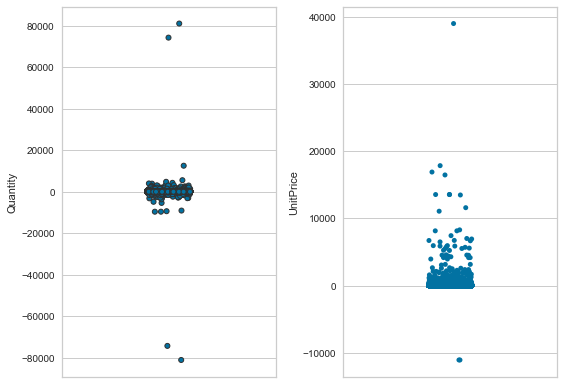

In [103]:
fig = plt.figure()

plt.subplot(1,2,1)
sns.stripplot(y='Quantity', linewidth=1, data=online)

plt.subplot(1,2,2)
sns.stripplot(y='UnitPrice', data=online)

plt.tight_layout()
plt.show()
fig.savefig("stripplots.png")

In [101]:
online[online['UnitPrice']==38970]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndexDay,CohortMonth,InvoiceMonth,CohortIndexMonth
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098.0,United Kingdom,2011-06-10,2011-06-10,1.0,2011-06,2011-06,1.0


In [102]:
online[online['Quantity']>70000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndexDay,CohortMonth,InvoiceMonth,CohortIndexMonth
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18,1.0,2011-01,2011-01,1.0
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-09,2011-05-18,202.0,2011-05,2011-12,8.0


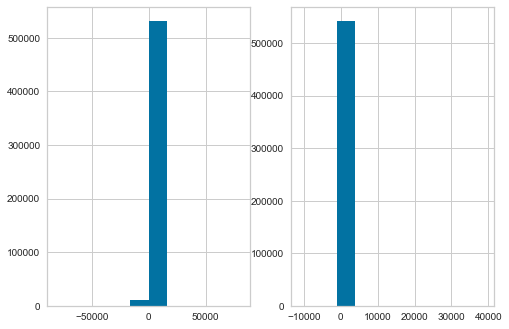

In [87]:
plt.figure()

plt.subplot(1,2,1)
plt.hist('Quantity', data=online)

plt.subplot(1,2,2)
plt.hist('UnitPrice', data=online)

plt.show()

In [23]:
grouping = online.groupby(['CohortMonth', 'CohortIndexMonth'])

# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndexMonth', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [24]:
### Calculate average price

In [25]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndexMonth']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndexMonth', values='UnitPrice')
print(average_price.round(1))

CohortIndexMonth  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  \
CohortMonth                                                                    
2010-12            3.2   3.2   3.2   3.6   2.9   5.0   3.2   3.2   3.5   3.0   
2011-01            3.5   3.7   3.1   8.4   3.2   3.2   2.9   2.7   2.6   5.5   
2011-02            3.3   4.4   4.8   3.1   3.0   2.8   2.8   3.2   2.9   2.9   
2011-03            3.3   5.0   3.7   3.3   3.6   2.8   2.8   2.8   2.7   2.5   
2011-04            3.4   4.0   3.3   2.7   3.0   2.9   2.9   2.8   2.6   NaN   
2011-05            4.6   3.2   2.6   3.2   2.7   2.5   2.6   2.5   NaN   NaN   
2011-06           10.4   3.2   3.3   2.8   2.6   3.5   2.3   NaN   NaN   NaN   
2011-07            4.5   3.5   2.7   2.7   2.4   2.4   NaN   NaN   NaN   NaN   
2011-08            3.0   5.4   5.7   7.0   6.8   NaN   NaN   NaN   NaN   NaN   
2011-09            3.2   3.6   2.9   2.6   NaN   NaN   NaN   NaN   NaN   NaN   
2011-10            4.0   2.7   2.6   NaN

In [26]:
average_price.shape

(13, 13)

## Visualising Cohorts

### Calculate Average Quantity

In [27]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndexMonth']) 

# Calculate the average quantity
cohort_data2 = grouping['Quantity'].mean()

# Reset the index of cohort_data
cohort_data2 = cohort_data2.reset_index()

# Create a pivot 
average_quantity = cohort_data2.pivot(index='CohortMonth', columns='CohortIndexMonth', values='Quantity')
print(average_quantity.round(1))

CohortIndexMonth  1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  \
CohortMonth                                                                    
2010-12           11.0  14.6  15.0  14.8  12.9  14.3  15.2  14.8  16.7  16.7   
2011-01           10.0  12.6  12.3  10.9  12.2  14.9  14.2  14.4  11.4   9.9   
2011-02           10.8  12.1  18.6  12.0  11.1  11.4  13.3  12.4  10.3  11.9   
2011-03            9.8   9.9  12.2   9.5  13.6  12.3  13.2  12.2  10.5   8.9   
2011-04            9.8  10.1   9.4  11.6  11.5   8.2   9.7   9.3   7.3   NaN   
2011-05           10.9   9.0  13.9  11.8  10.9   8.7  10.1   7.4   NaN   NaN   
2011-06           10.3  13.7  10.5  13.3  10.2   9.8   9.3   NaN   NaN   NaN   
2011-07            9.7  12.7   7.1   7.8   6.0   7.0   NaN   NaN   NaN   NaN   
2011-08            9.9   6.0   5.3   6.0   7.0   NaN   NaN   NaN   NaN   NaN   
2011-09           11.9   5.5   7.6   8.8   NaN   NaN   NaN   NaN   NaN   NaN   
2011-10            8.4   6.9   8.0   NaN

In [28]:
### Visualize average quantity metric

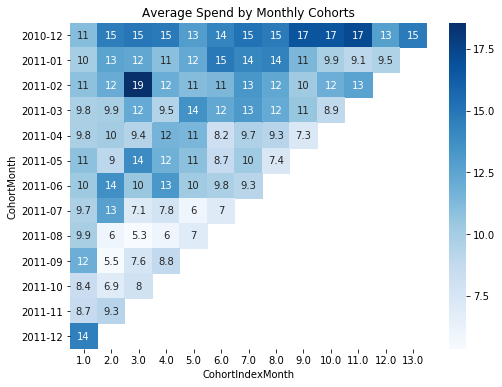

In [29]:
# Import seaborn package as sns
import seaborn as sns

# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8,6))

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data=average_quantity, annot=True, cmap='Blues')
plt.show()

## Section 2: Recency, Frequency, Monetary (RFM) segmentation

- RFM: https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6

In [30]:
df1= online.copy(deep=True)

In [31]:
df1 = df1[(df1['Quantity']>=0)]
df1 = df1[(df1['UnitPrice']>=0)]
df1.describe()

,Quantity,UnitPrice,CustomerID,CohortIndexDay,CohortIndexMonth
count,531283.000000,531283.000000,397924.000000,397924.000000,397924.000000
mean,10.655299,3.898954,15294.315171,131.409546,5.179265
std,156.830617,35.876279,1713.169877,119.348741,3.861138
min,1.000000,0.000000,12346.000000,1.000000,1.000000
25%,1.000000,1.250000,13969.000000,1.000000,1.000000
50%,3.000000,2.080000,15159.000000,111.000000,4.000000
75%,10.000000,4.130000,16795.000000,233.000000,8.000000
max,80995.000000,13541.330000,18287.000000,374.000000,13.000000


### Create RFM Table

In [32]:
df1['TotalPrice'] = df1['Quantity']*df1['UnitPrice']

In [33]:
print(f"Min: {df1['InvoiceDate'].min()}", f"Max: {df1['InvoiceDate'].max()}")

Min: 2010-12-01 08:26:00 Max: 2011-12-09 12:50:00


In [34]:
NOW = dt.datetime(2011,12,10)

In [35]:
# Calculate Recency, Frequency and Monetary value for each customer 
datamart = df1.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': lambda x: len(x),
    'TotalPrice': lambda x: x.sum()})

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalPrice': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


### Calculate quartiles

The lowest recency, highest frequency and monetary amounts are our best customers.

In [36]:
# Recency quartile
    # Store labels from 4 to 1 in a decreasing order
r_labels = range(4, 0, -1)
    # Create a spend quartile with 4 groups and pass the previously created labels 
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
    # Assign the quartile values to the Recency_Quartile column in `data`
datamart = datamart.assign(R = r_quartiles.values)
# Frequency quartiles
f_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
datamart = datamart.assign(F = f_quartiles.values)
# Monetary quartiles
m_labels = range(1,5)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartiles.values)
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,4
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,18,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


RFM segments split the customer base into an imaginary 3D cube which is hard to visualize. However, we can sort it out.

Add a new column to combine RFM score: 12 is the highest score as we determined earlier.

In [37]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [38]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,4,114,6.0
12347.0,2,182,4310.00,4,4,4,444,12.0
12348.0,75,31,1797.24,2,2,4,224,8.0
12349.0,18,73,1757.55,3,3,4,334,10.0
12350.0,310,17,334.40,1,1,2,112,4.0


In [39]:
datamart.loc[[12747, 12748, 12749, 12820 ]]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,103,4196.01,4,4,4,444,12.0
12748,0,4596,33719.73,4,4,4,444,12.0
12749,3,199,4090.88,4,4,4,444,12.0
12820,3,59,942.34,4,3,3,433,10.0


In [40]:
datamart[datamart['RFM_Segment']=='444'].sort_values(
    'MonetaryValue', ascending=False).head(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
14646.0,1,2080,280206.02,4,4,4,444,12.0
18102.0,0,431,259657.30,4,4,4,444,12.0
17450.0,8,337,194550.79,4,4,4,444,12.0
14911.0,1,5677,143825.06,4,4,4,444,12.0
14156.0,9,1400,117379.63,4,4,4,444,12.0
17511.0,2,963,91062.38,4,4,4,444,12.0
16684.0,4,277,66653.56,4,4,4,444,12.0
14096.0,4,5111,65164.79,4,4,4,444,12.0
13694.0,3,568,65039.62,4,4,4,444,12.0


In [41]:
datamart.loc[[18102, 17450, 17511, 16684 ]]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
18102,0,431,259657.30,4,4,4,444,12.0
17450,8,337,194550.79,4,4,4,444,12.0
17511,2,963,91062.38,4,4,4,444,12.0
16684,4,277,66653.56,4,4,4,444,12.0


### Creating Custom Segments

In [42]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with the top 5 rows to the console.
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,1,1,4,114,6.0,Middle
12347.0,2,182,4310.00,4,4,4,444,12.0,Top
12348.0,75,31,1797.24,2,2,4,224,8.0,Middle
12349.0,18,73,1757.55,3,3,4,334,10.0,Top
12350.0,310,17,334.40,1,1,2,112,4.0,Low


### Analysing Customer Segments

In [43]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         191.6      15.1         267.3  1287
Middle       71.7      50.2        1078.8  1789
Top          19.4     228.6        5255.3  1263


## Section 3: Data pre-processing for clustering

## Centre and Scaling

In [44]:
c_count=df1['InvoiceNo'].str.contains('C').sum()
if c_count>0:
    print ("There are {m} cases".format(m=c_count))
else:
    print("nah mate")

nah mate


In [45]:
df1.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndexDay,CohortMonth,InvoiceMonth,CohortIndexMonth,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12,1.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1.0,2010-12,2010-12,1.0,20.34


In [46]:
# Calculate Recency, Frequency and Monetary value for each customer 
rfm = df1.groupby(['CustomerID']).agg({
    'InvoiceDay': lambda x: (NOW - x.max()).days,
    'InvoiceNo': lambda x: len(x),
    'TotalPrice': lambda x: x.sum()})

# Rename the columns 
rfm.rename(columns={'InvoiceDay': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalPrice': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


In [47]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4339.000000,4339.000000,4339.000000
mean,93.041484,91.708689,2053.793018
std,100.007757,228.792852,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,307.245000
50%,51.000000,41.000000,674.450000
75%,142.500000,100.000000,1661.640000
max,374.000000,7847.000000,280206.020000


In [48]:
df[df.Description=='ASSTD DESIGN 3D PAPER STICKERS'].mean()

Quantity        359.078947
UnitPrice         0.573947
CustomerID    15178.432432
dtype: float64

In [49]:
df[df.CustomerID==13256.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom


In [50]:
rfm[rfm['MonetaryValue']==0]

,Recency,Frequency,MonetaryValue
CustomerID,,,
13256.0,15,1,0.0


In [51]:
rfm.drop(13256.0, inplace=True)

In [52]:
rfm[rfm['MonetaryValue']==0]

,Recency,Frequency,MonetaryValue
CustomerID,,,


In [53]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,93.059474,91.729599,2054.266460
std,100.012264,228.815081,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,307.415000
50%,51.000000,41.000000,674.485000
75%,142.750000,100.000000,1661.740000
max,374.000000,7847.000000,280206.020000


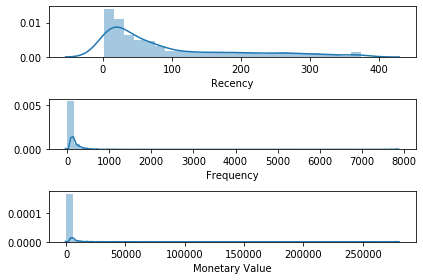

In [54]:
# Plot recency distribution
fig = plt.figure()
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])
plt.xlabel("Recency")

# Plot frequency distribution
plt.subplot(3,1,2); sns.distplot(rfm['Frequency'])
plt.xlabel("Frequency")

# Plot monetary value distribution
plt.subplot(3,1,3); sns.distplot(rfm['MonetaryValue'])
plt.xticks()
plt.xlabel("Monetary Value")

# Show the plot
plt.tight_layout()
plt.show()

In [55]:
fig.savefig("Pre-standardisation.png")

In [56]:
# Unskew the data
rfm_log = np.log(rfm)

# Initialize a standard scaler and fit it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

# Scale and center the data
rfm_normalized = scaler.transform(rfm_log)

# Create a pandas DataFrame
rfm_normalized = pd.DataFrame(data=rfm_normalized, index=rfm.index, columns=rfm.columns)

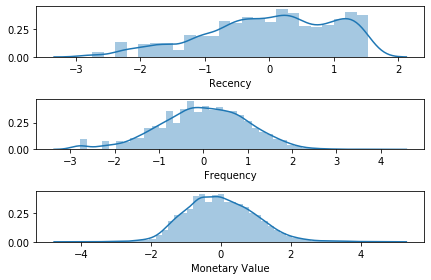

In [57]:
# Plot recency distribution
fig = plt.figure()
plt.subplot(3, 1, 1); sns.distplot(rfm_normalized['Recency'])
plt.xlabel("Recency")

# Plot frequency distribution
plt.subplot(3,1,2); sns.distplot(rfm_normalized['Frequency'])
plt.xlabel("Frequency")

# Plot monetary value distribution
plt.subplot(3,1,3); sns.distplot(rfm_normalized['MonetaryValue'])
plt.xticks()
plt.xlabel("Monetary Value")

# Show the plot
plt.tight_layout()
plt.show()

In [58]:
fig.savefig("Post-standardisation.png")

## Section 4: Customer Segmentation with K-means

- RFM + Cluster (chooses 2 clusters): https://github.com/danieltlo/Customer_Segmentation/blob/master/Customer%20Segmentation.ipynb

In [59]:
# Import KMeans 
from sklearn.cluster import KMeans

In [60]:
sse={}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(rfm_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

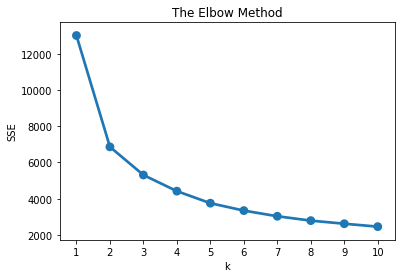

In [61]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

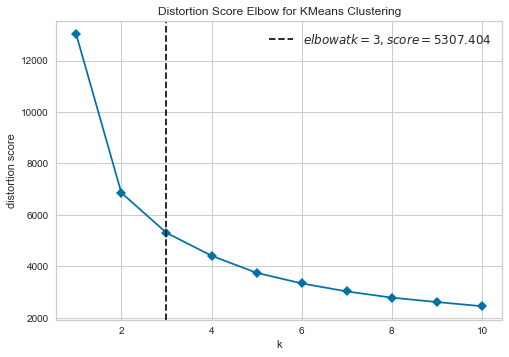

In [62]:
from yellowbrick.cluster import KElbowVisualizer

fig = plt.figure()
# Instantiate the clustering model and visualizer
model = KElbowVisualizer(kmeans, k=(1,11), timings=False)
model.fit(rfm_normalized) # Fit the data to the visualizer
model.show() # Finalize and render the figure
plt.show()

In [63]:
fig.savefig("Elbow Method")

https://stackabuse.com/k-means-clustering-with-scikit-learn/

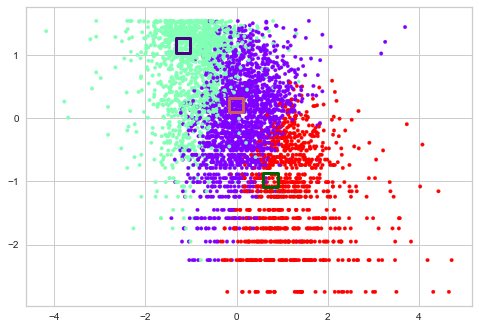

In [64]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_normalized)
cluster_labels=kmeans.labels_
# Getting the Centroid values
centroids = kmeans.cluster_centers_
plt.scatter(rfm_normalized.MonetaryValue,rfm_normalized.Recency, c=cluster_labels, cmap='rainbow', marker='.')
centroid_colors = ['indianred', 'darkgreen', 'indigo',]
plt.scatter(centroids[:,0], centroids[:,1], marker='s', edgecolors = centroid_colors, linewidth = 3, facecolors = 'None', s=200);
plt.show()

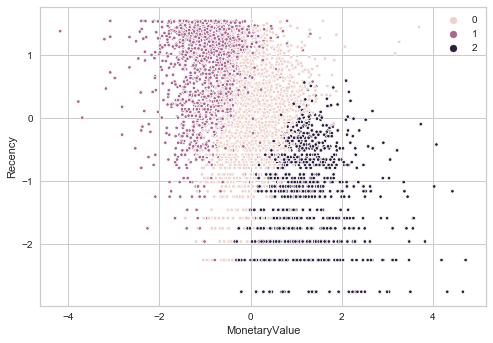

In [65]:
sns.scatterplot(rfm_normalized.MonetaryValue,rfm_normalized.Recency, hue=cluster_labels, cmap='rainbow', marker = '.', legend='full')
plt.show()

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py

In [66]:
# Create a DataFrame by adding a new cluster label column
rfm_norm_k3 = rfm_normalized.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = rfm_norm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          -0.0       0.2           0.1  1863
1           0.7      -1.0          -0.9  1518
2          -1.2       1.1           1.2   957

In [67]:
rfm_norm_k3.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,1.435416,-2.775709,3.698719,0
12347.0,-1.953393,1.149573,1.410201,2
12348.0,0.382865,-0.185519,0.716419,0
12349.0,-0.619183,0.460502,0.698706,0
12350.0,1.401368,-0.638671,-0.617446,1


In [68]:
centroids

array([[-0.00279632,  0.21089837,  0.12337263],
       [ 0.74606208, -0.97799521, -0.91989704],
       [-1.17953021,  1.14322972,  1.22115678]])

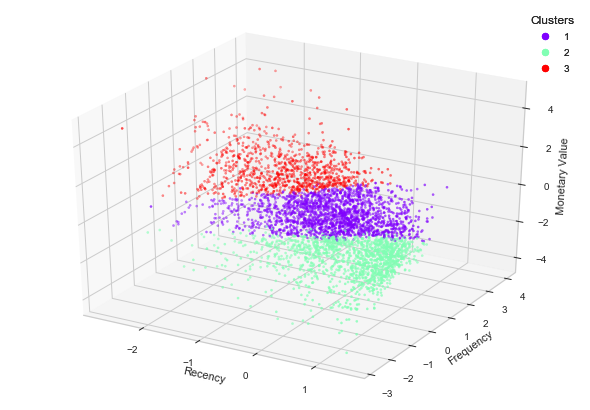

In [69]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = Axes3D(fig)
scatter = ax.scatter(rfm_norm_k3['Recency'], rfm_norm_k3['Frequency'], rfm_norm_k3['MonetaryValue'], c=rfm_norm_k3.Cluster+1, cmap='rainbow', marker='.')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
#Label axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')

plt.show()

In [70]:
fig.savefig("3D Clusters.png")

In [71]:
# Melt the normalized dataset and reset the index
rfm_melt = pd.melt(
    rfm_norm_k3.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables                  
    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
    var_name='Metric', value_name='Value')

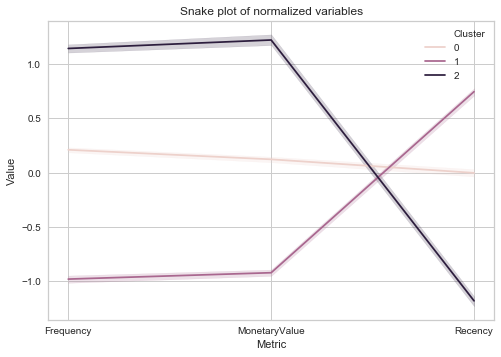

In [72]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=rfm_melt, x='Metric', y='Value', hue='Cluster', legend='full')
plt.show()

In [73]:
# Create a DataFrame by adding a new cluster label column
rfm_k3 = rfm.assign(Cluster=cluster_labels)

In [74]:
# Calculate average RFM values for each cluster
cluster_avg = rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.26      -0.29          -0.43
1           0.86      -0.84          -0.86
2          -0.85       1.88           2.20


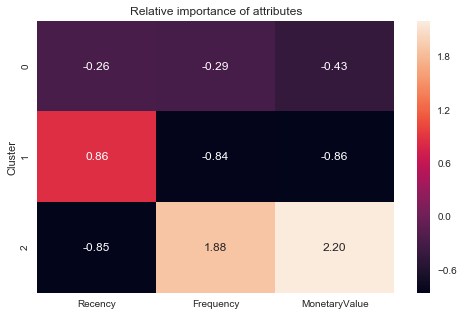

In [75]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 5))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f')
plt.show()

# Step 1: Create clusters and map onto df

In [76]:
rfm_k3.sort_values(by='MonetaryValue', ascending=False).head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
14646.0,2,2080,280206.02,2
18102.0,1,431,259657.30,2
17450.0,9,337,194550.79,2
16446.0,1,3,168472.50,2
14911.0,2,5677,143825.06,2


In [77]:
# Group the data by cluster
grouped = rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          68.7      65.5        1163.8  1863
1         172.7      15.0         295.4  1518
2          14.0     264.6        6577.8   957

In [78]:
# Create a DataFrame by adding a new cluster label column
df_k3 = df.join(rfm_k3.Cluster, on='CustomerID')

In [79]:
df_k3.Cluster.value_counts()

2.0    258923
0.0    124475
1.0     23342
Name: Cluster, dtype: int64

In [80]:
df_k3[df_k3['Cluster']==0].to_excel('Clusterlow.xlsx')
df_k3[df_k3['Cluster']==1].to_excel('Clusterhigh.xlsx')
df_k3[df_k3['Cluster']==2].to_excel('Clustermed.xlsx')